<a href="https://colab.research.google.com/github/CIA-Oceanix/DLOA2023/blob/main/lectures/notebooks/notebook_PytorchLightning_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pytorch Lightning for training a MLP MNIST


---



In [1]:
pip install pytorch_lightning==1.6.5 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery 3.10.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery-connection 1.12.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-

In [2]:
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

## 1- Data management (Same as yesterday) <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

#train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
#test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 74345495.88it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 119110810.05it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27049858.40it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20309732.16it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



#### **Dataloader creation** - Check data loader documentation ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets. <a class="anchor" id="question_1_2"></a>

In [4]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 64
valid_size = 0.2
train_size = 0.3

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED

  total_train = len(train_data)
  num_val = int(total_train * valid_size)
  num_train = total_train - num_val

  tr_data, val_data = torch.utils.data.random_split(train_data, [num_train, num_val])
  train_loader = torch.utils.data.DataLoader(tr_data, batch_size = batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

  return train_loader, valid_loader, test_loader

In [5]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) # TO DO

#### **MNIST samples** - Visualize some images from the training set with corresponding ground truth labels. <a class="anchor" id="question_1_3"></a>

## 1- Comparing Convolutional neural network and Multilayer perceptron using **Pytorch Lightning** (CNN vs MLP)

#### Network definitions

Below are the models that will be compared using pytorch lightning

In [14]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_1, hidden_2 = 512, 256
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.fc3 = nn.Linear(hidden_2,10)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class CNN(nn.Module):

    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxp1 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(0.25)

        self.fcon1 = nn.Linear(64*4*4, 128)
        self.relu5 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.fcon2 = nn.Linear(128, 10)

    def forward(self,x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxp1(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.maxp2(out)
        out = self.drop1(out)
        out = out.view(out.size(0), -1)
        out = self.fcon1(out)
        out = self.relu5(out)
        out = self.drop2(out)
        out = self.fcon2(out)
        return out

#### Lightning module definitions

- [x] **TODO 1: implement the `__init__` so that the lightning module can use either of the above models**

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class LitModel(pl.LightningModule):
    def __init__(self, model_name):
        super().__init__()

        if model_name == 'mlp':
            self.model = MLP()
        elif model_name == 'cnn':
            self.model = CNN()
        else:
          raise Exception(f'Unknown model {model}')

        self.criterion = nn.CrossEntropyLoss()
        self.test_data = None

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self(data)
        loss = self.criterion(output, label)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx): ## TODO 1
        data, label = batch
        output = self(data)
        loss = self.criterion(output, label)
        self.log('val_loss', loss) ## TODO 3
        return loss

    def configure_optimizers(self): ## TODO 1
        return torch.optim.SGD(self.parameters(),lr = 0.01)

    def test_step(self, batch, batch_idx): ## TODO 5
        data, label = batch
        output = self(data)
        loss = self.criterion(output, label)
        self.log('test_loss', loss)

        preds = torch.max(output.cpu(), 1)[1]
        return label.cpu(), preds

    def test_epoch_end(self, test_step_outputs): ## TODO 5
        list_of_labels, list_of_preds = zip(*test_step_outputs)
        labels, preds = torch.cat(list_of_labels),  torch.cat(list_of_preds)

        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        correct = np.squeeze(preds.eq(labels.data.view_as(preds)))
        for i in range(len(labels)):
            digit = labels.data[i]
            class_correct[digit] += correct[i].item()
            class_total[digit] += 1

        for i in range(10):
            print('test accuracy of %s: %2d%% (%2d/%2d)'
                % (i, 100 * class_correct[i] / class_total[i],
                   np.sum(class_correct[i]), np.sum(class_total[i])))

        print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)'
             % (100. * np.sum(class_correct) / np.sum(class_total),
                np.sum(class_correct), np.sum(class_total)))

        self.test_data = labels, preds



#### MLP training

- [x] **TODO: Instantiate an Lightning module for MLP training**
- [x] **TODO: Instantiate the mlp_model_checkpoint**
  - [x] that will save the model with the best validation loss
- [x] **TODO: Instantiate the mlp_logger**
  - [x] that will save logs in a folder `logs`
  - [x] with an experiment name `mlp_mnist`
- [x] **TODO: Instantiate the mlp_trainer with:**
  - [x] gpu training
  - [x] 10 epochs training
  - [x] using the model_checkpoint


In [17]:
mlp_model = LitModel('mlp')
mlp_model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss')
mlp_logger = pl.loggers.CSVLogger('logs', name='mlp_mnist')
mlp_trainer = pl.Trainer(
    gpus=1,
    max_epochs=5,
    callbacks=[mlp_model_checkpoint],
    logger=mlp_logger
  )

mlp_trainer.fit(mlp_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

print(f"\n\n>>>>>>>>>>>>>   Logs stored at {mlp_logger.log_dir}/metrics.csv")
print(f"""\n>>>>>>>>>>>>    Best model saved at {mlp_model_checkpoint.best_model_path}
    with validation loss {mlp_model_checkpoint.best_model_score}""")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MLP              | 535 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.143     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd4fc915a20>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd4fc915a20>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd4fc915a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd4fc915a20>    
assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
AssertionError    : self._shutdown_workers()
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():

  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



>>>>>>>>>>>>>   Logs stored at logs/mlp_mnist/version_2/metrics.csv

>>>>>>>>>>>>    Best model saved at logs/mlp_mnist/version_2/checkpoints/epoch=4-step=3750.ckpt
    with validation loss 0.3255135416984558


#### CNN training
- [x] **TODO: Instantiate an Lightning module for CNN training**
- [x] **TODO: Instantiate the cnn_model_checkpoint**
  - [x] that will save the model with the best validation loss
- [x] **TODO: Instantiate the cnn_logger**
  - [x] that will save logs in a folder `logs`
  - [x] with an experiment name `cnn_mnist`
- [x] **TODO: Instantiate the cnn_trainer with:**
  - [x] gpu training
  - [x] 10 epochs training
  - [x] using the model_checkpoint

In [18]:
cnn_model = LitModel('cnn')
cnn_model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss')
cnn_logger = pl.loggers.CSVLogger('logs', name='cnn_mnist')
cnn_trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
    callbacks=[cnn_model_checkpoint],
    logger=cnn_logger
  )

cnn_trainer.fit(cnn_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

print(f"\n\n>>>>>>>>>>>>>   Logs stored at {cnn_logger.log_dir}/metrics.csv")
print(f"""\n>>>>>>>>>>>>    Best model saved at {cnn_model_checkpoint.best_model_path}
    with validation loss {cnn_model_checkpoint.best_model_score}""")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | CNN              | 225 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
225 K     Trainable params
0         Non-trainable params
225 K     Total params
0.901     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



>>>>>>>>>>>>>   Logs stored at logs/cnn_mnist/version_0/metrics.csv

>>>>>>>>>>>>    Best model saved at logs/cnn_mnist/version_0/checkpoints/epoch=9-step=7500.ckpt
    with validation loss 0.06030462309718132


### Compare training convergence
- [x] **TODO: Plot the validation loss and training loss for both experiment in the same graph**
  - [x] load the MLP log file in the `mlp_training_metrics_df`, average by epoch, select relevant columns and rename them so that they contain 'MLP'
  - [x] load the CNN log file in the `cnn_training_metrics_df`, average by epoch, select relevant columns and rename them so that they contain 'CNN'
  - [x] concatenate the dataframes and plot

<Axes: xlabel='epoch'>

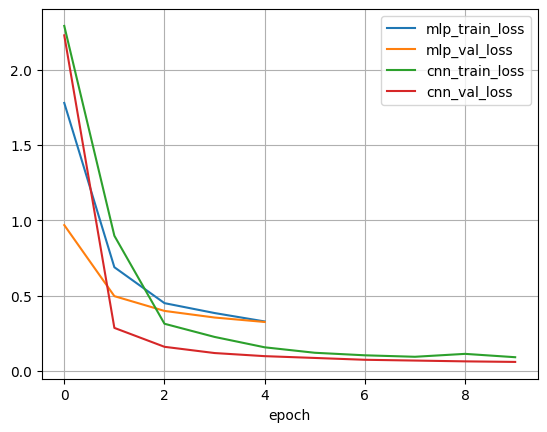

In [19]:
mlp_training_metrics_df = (
    pd.read_csv(f'{mlp_logger.log_dir}/metrics.csv').groupby('epoch').mean()
    [['train_loss', 'val_loss']].rename(lambda col_name: f'mlp_{col_name}', axis=1)
)
cnn_training_metrics_df = (
    pd.read_csv(f'{cnn_logger.log_dir}/metrics.csv') .groupby('epoch').mean()
    [['train_loss', 'val_loss']].rename(lambda col_name: f'cnn_{col_name}', axis=1)
)
pd.concat([mlp_training_metrics_df, cnn_training_metrics_df], axis=1).plot(grid=True)

### Load best model and display accuracy per digit
- [x] **TODO: Display accuracy per digit for best mlp model**
  - [x] instantiate best mlp checkpoint into `best_mlp`
  - [x] use the mlp_trainer to lauch the diagnostic on the test data
- [x] **TODO: Display accuracy per digit for best cnn model**
  - [x] instantiate best cnn checkpoint into `best_cnn`
  - [x] use the cnn_trainer to lauch the diagnostic on the test data  
  

In [20]:
print("\n\n############## MLP #############\n")
best_mlp = LitModel.load_from_checkpoint(mlp_model_checkpoint.best_model_path, model_name='mlp')
mlp_trainer.test(best_mlp, dataloaders=test_loader)

print("\n\n############## CNN #############\n")
best_cnn = LitModel.load_from_checkpoint(cnn_model_checkpoint.best_model_path, model_name='cnn')
cnn_trainer.test(best_cnn, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




############## MLP #############



Testing: 0it [00:00, ?it/s]

test accuracy of 0: 98% (965/980)
test accuracy of 1: 97% (1111/1135)
test accuracy of 2: 86% (897/1032)
test accuracy of 3: 88% (894/1010)
test accuracy of 4: 93% (917/982)
test accuracy of 5: 85% (767/892)
test accuracy of 6: 94% (903/958)
test accuracy of 7: 91% (936/1028)
test accuracy of 8: 85% (836/974)
test accuracy of 9: 89% (905/1009)

test accuracy (overall): 91.31% (9131/10000)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.30294209718704224    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




############## CNN #############



Testing: 0it [00:00, ?it/s]

test accuracy of 0: 99% (975/980)
test accuracy of 1: 99% (1127/1135)
test accuracy of 2: 99% (1022/1032)
test accuracy of 3: 98% (997/1010)
test accuracy of 4: 98% (963/982)
test accuracy of 5: 97% (871/892)
test accuracy of 6: 98% (944/958)
test accuracy of 7: 98% (1008/1028)
test accuracy of 8: 96% (939/974)
test accuracy of 9: 97% (987/1009)

test accuracy (overall): 98.33% (9833/10000)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05066514015197754    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.05066514015197754}]

### Display confusion matrices

- [x] **TODO: Recover test predictions and labels from best_mlp and best_cnn **

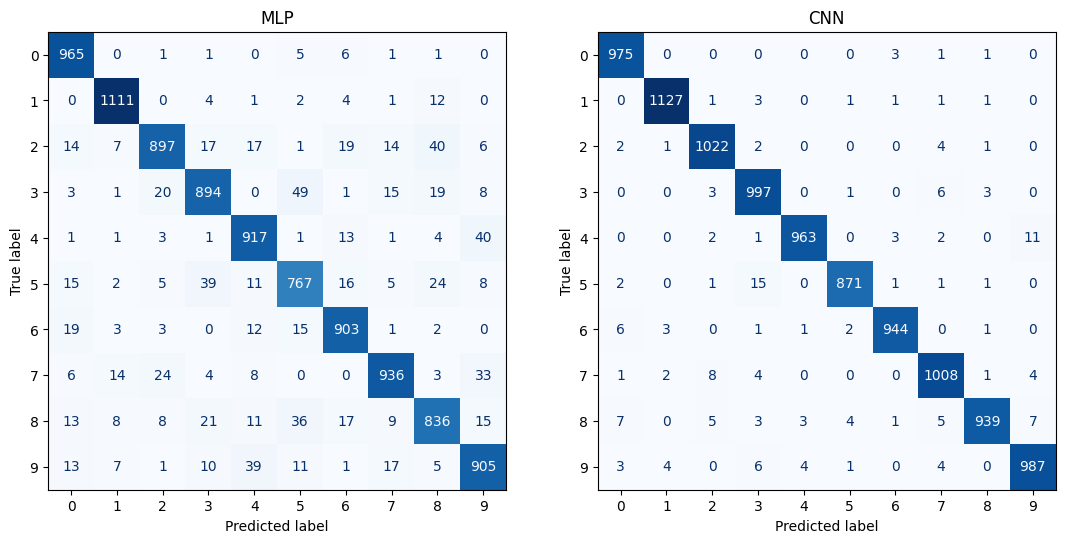

In [21]:
import sklearn.metrics
mlp_labels, mlp_preds = best_mlp.test_data
cnn_labels, cnn_preds = best_cnn.test_data

fig, (ax_mlp, ax_cnn) = plt.subplots(1,2, figsize=(13, 6))
ax_mlp.set_title('MLP')
ax_cnn.set_title('CNN')

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(mlp_labels, mlp_preds, cmap='Blues', ax=ax_mlp, colorbar=False)
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(cnn_labels, cnn_preds, cmap='Blues', ax=ax_cnn, colorbar=False)